In [58]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import statistics
import seaborn as sns
import random
import numpy.linalg as la
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix

In [59]:
### Q1: Understanding the data-Exploration (Exploratory data analysis)

In [60]:
#Ensures that any random values generated using the random method will be consistent every time the script runs
#https://docs.python.org/3/library/random.html
random.seed(42)
np.random.seed(42)

In [61]:
# Step 1: Load the MovieLens 100k dataset
# Load data and label data as dataframe in ways that the user can make sense. Each file was investigated to find the separator
#and the labels for the columns
ratings = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
users = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
movies = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.item', sep='|', encoding='latin-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)])
occupation= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.occupation', sep='|', names=['occupation_name'])
infos= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.info', sep='|', names=['number', 'info'])
genre= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.genre', sep='|', names=['movie_type', 'type_id'])
test = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
training = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [62]:
# Check if the datatypes are correct (we wanted to check if the dataset is consistent). 
# We chose not to proceed with casting/converting columns into a different type in this step.
print("The datatype per column for movies is:") 
movies.info() # e.g. release_date is type object and not date-type
print()
print("The datatype per column for users is:") 
users.info()
print()
print("The datatype per column for ratings is:") 
ratings.info()

The datatype per column for movies is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   genre_0             1682 non-null   int64  
 6   genre_1             1682 non-null   int64  
 7   genre_2             1682 non-null   int64  
 8   genre_3             1682 non-null   int64  
 9   genre_4             1682 non-null   int64  
 10  genre_5             1682 non-null   int64  
 11  genre_6             1682 non-null   int64  
 12  genre_7             1682 non-null   int64  
 13  genre_8             1682 non-null   int64  
 14  genre_9             1682 non-null   int64  
 15  genre_10        

In [63]:
# Check for NaN values in the key-data of our dataset.
print("There are %s zero values in movies which it's expected since the column video_release_date has no values." %(movies.isnull().sum().sum()))
print("There are %s zero values in users." %(users.isnull().sum().sum()))
print("There are %s zero values in ratings." %(ratings.isnull().sum().sum()))

# We also printed nulls per column as follows (the same result as the previous query but we were intesting to print the NaN values per column).
#movies.isnull().sum()
#users.isnull().sum()
#ratings.isnull().sum() 

There are 1686 zero values in movies which it's expected since the column video_release_date has no values.
There are 0 zero values in users.
There are 0 zero values in ratings.


In [64]:
# Check for duplicates.
print("There are %s zero values in ratings." %(ratings.duplicated().sum()))
print("There are %s zero values in users." % (users.duplicated().sum()))
print("There are %s zero values in movies." % (movies.duplicated().sum()))

There are 0 zero values in ratings.
There are 0 zero values in users.
There are 0 zero values in movies.


In [65]:
# Check unique values for some key-fields.
print("There are %s unique movie titles and %d duplicated titles." %(movies['movie_title'].nunique(), movies['movie_title'].duplicated().sum()))
print("Each movie is rated with: %s value. There is no zero rating." % sorted(map(int, ratings['rating'].unique())))

There are 1664 unique movie titles and 18 duplicated titles.
Each movie is rated with: [1, 2, 3, 4, 5] value. There is no zero rating.


In [66]:
# How many ratings are in the dataset.
n_ratings = len(ratings)
#How many movies are in the dataset.
n_movies = ratings['item_id'].nunique()
#How many users are in the dataset.
n_users = ratings['user_id'].nunique()

print("Number of ratigs: %s" %(n_ratings))
print("Number of unique movie_id's: %s" %(n_movies))
print("Number of unique users: %s" %(n_users))
print("Average number of ratings per user: %s" %(round(n_ratings/n_users, 2)))
print("Average number of ratings per movie: %s" %(round(n_ratings/n_movies, 2)))

Number of ratigs: 100000
Number of unique movie_id's: 1682
Number of unique users: 943
Average number of ratings per user: 106.04
Average number of ratings per movie: 59.45


In [67]:
# Let's see the top 6 genres by the total number of movies
top6_genre = (movies.iloc[:, 6:-1] # get the genre columns only
              .sum() # sum them up
              .sort_values(ascending=False) # sort descending
              .head(6) # get the first 6
              .index.values # get the genre names
              )
    
top6_genre

array(['genre_8', 'genre_5', 'genre_1', 'genre_16', 'genre_14', 'genre_2'],
      dtype=object)

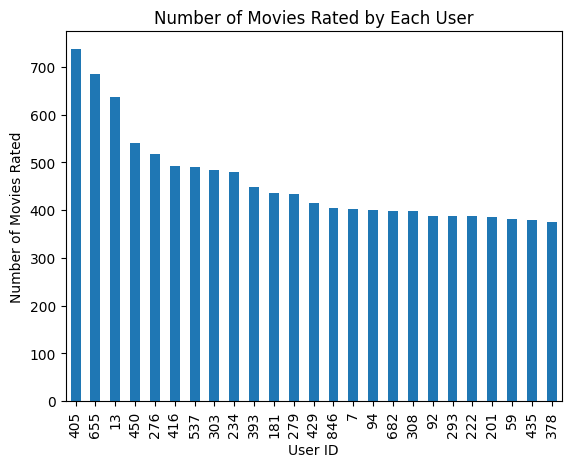

In [68]:
#Step 2
# Basic Descriptive Statistics
# Plot number of movies seen by each user
user_movie_counts = ratings['user_id'].value_counts().head(25)
# head(25) to plot the top 25, because the chart was too crowded, this shows us the top users
plt.figure()
user_movie_counts.plot(kind='bar')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.title('Number of Movies Rated by Each User')
plt.show()

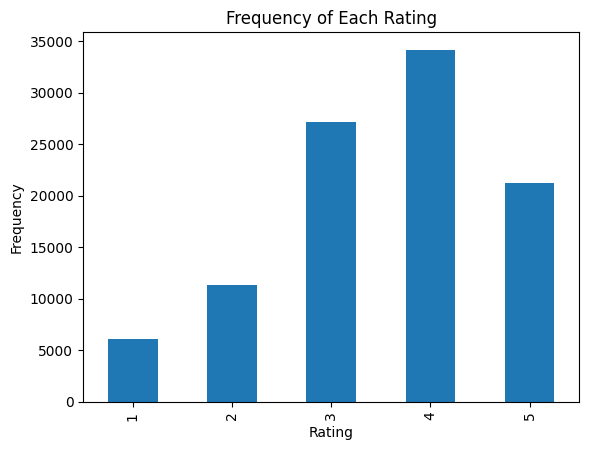

In [69]:
# Plot the frequency of each rating
rating_counts = ratings['rating'].value_counts().sort_index()
plt.figure()
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Each Rating')
plt.show()

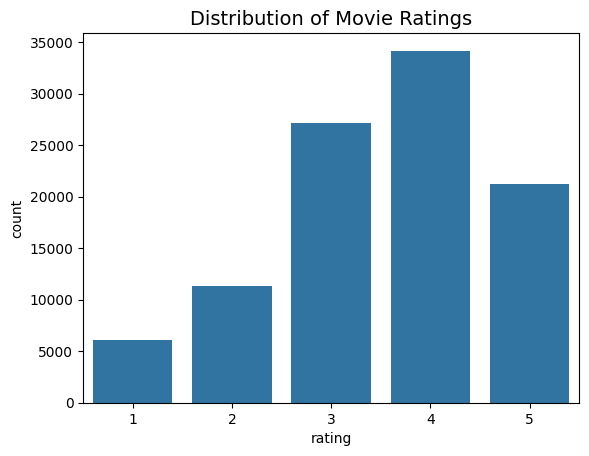

In [70]:
#Να το κάνουμε λίγο πιο όμορφο?(Άξονας x)
#Let's check the distribution of movie ratings.
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Movie Ratings', fontsize = 14)
plt.show()

In [71]:
#More descriptive statistics of the data sets, to understand the spread of the data further and make an informed decision
#on the outliers

# Mean, median, and standard deviation of movies seen by each user
#count of the number of time each unique user id appears in column 
user_movie_counts = ratings['user_id'].value_counts()
#statistics of the user movie counts
mean_movies_rated = user_movie_counts.mean()
median_movies_rated = user_movie_counts.median()
std_movies_rated = user_movie_counts.std()
Q3_movies_rated = user_movie_counts.quantile(0.75)
# Largest (maximum) number of movies rated by a user
max_movies_rated = user_movie_counts.max()
# Smallest (minimum) number of movies rated by a user
min_movies_rated = user_movie_counts.min()

# Creating a summary table to visualize the results
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Top Quartile','Standard Deviation', 'Minimum', 'Maximum'],
    'Movies Rated by User': [mean_movies_rated, median_movies_rated, Q3_movies_rated, std_movies_rated, max_movies_rated, min_movies_rated]
})

# Display the table
print(summary_table.round(1))

from scipy.stats import percentileofscore
#We want to see what percentage of the values are above 1.5 standard deviations of the mean which is 106 + 151.35. round to nearest whole number
value = 257
# Calculate the percentile of this value within the distribution of movie counts
percentile = percentileofscore(user_movie_counts, value, kind='rank')

#####change the print syntax to be simpler
print(f"The percentage of users that have rated less than or equal to 257 movies is: {percentile.round(2)}%")

            Statistic  Movies Rated by User
0                Mean                 106.0
1              Median                  65.0
2        Top Quartile                 148.0
3  Standard Deviation                 100.9
4             Minimum                 737.0
5             Maximum                  20.0
The percentage of users that have rated less than or equal to 257 movies is: 90.67%


In [72]:
#Να προσθέσουμε λίγο κείμενο?
#Μean global rating.
print("Mean global rating: %s" %(round(ratings['rating'].mean(), 2)))
#Mean rating per user.
mean_rating = ratings.groupby('user_id')[['rating']].mean()
print("Mean rating per user: %s" %(round(mean_rating.mean(), 2)))

Mean global rating: 3.53
Mean rating per user: rating    3.59
dtype: float64


In [73]:
#More descriptive statistics of the data sets, to understand the spread of the data further and make an informed decision
#on the outliers

# Mean, median, and standard deviation of ratings recieved for each movie
#count of the number of time each movie (item) appears in column 
movie_rating_counts = ratings['item_id'].value_counts()
#statistics of the movie ratings counts
mean_ratings_received = movie_rating_counts.mean()
median_ratings_received = movie_rating_counts.median()
std_ratings_received = movie_rating_counts.std()
Q3_ratings_received = movie_rating_counts.quantile(0.75)
# Largest (maximum) number of ratings for a movie
max_ratings_received = movie_rating_counts.max()
# Smallest (minimum) number of ratings for a movie
min_ratings_received = movie_rating_counts.min()

# Creating a summary table to visualize the results
summary_table2 = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Top Quartile','Standard Deviation', 'Minimum', 'Maximum'],
    'Ratings Received for Each Movie': [mean_ratings_received, median_ratings_received, Q3_ratings_received, std_ratings_received, max_ratings_received, min_ratings_received]
})

# Display the table
print(summary_table2.round(1))

#We want to see what percentage of the values are above 1.5 standard deviations of the mean which is 59.5 + 120.6. round to nearest whole number
value = 180
# Calculate the percentile of this value within the distribution of movie rating counts
percentile2 = percentileofscore(movie_rating_counts, value, kind='rank')

#####change the print syntax to be simpler
print(f"The percentage of movies that have been rated less than or equal to 180 times is: {percentile2.round(2)}%")

# we decide to do 1.5 standard deviations for this dataset as well

            Statistic  Ratings Received for Each Movie
0                Mean                             59.5
1              Median                             27.0
2        Top Quartile                             80.0
3  Standard Deviation                             80.4
4             Minimum                            583.0
5             Maximum                              1.0
The percentage of movies that have been rated less than or equal to 180 times is: 91.8%


In [74]:
#Ας παίξουμε λίγο
#Let's find the most frequently rated movies. In order to to that we need to merge ratings with movies.
# Let's create a common dataset. The common key between ratings and movies is the 'items_id' and ‘movie_id’ column respectively.
# First we have to rename the column.
ratings1 = ratings.copy()
##
#data.drop(['timestamp', 'video_release_date', 'IMDb_URL'], axis = 1, inplace = True)
ratings1.rename(columns={'item_id': 'movie_id'}, inplace=True)
# Then we combined them.
data = pd.merge(ratings1, movies, on = 'movie_id')
# In order to have a 'cleaner' view of our data we dropped some columns.
data.drop(['timestamp', 'video_release_date', 'IMDb_URL'], axis = 1, inplace = True)

#Most rated movies
data['movie_title'].value_counts()[0:10]

movie_title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64

In [75]:
#Let's find the highest rated movie
mean_rating = ratings.groupby('item_id')[['rating']].mean()
highest_rated = mean_rating['rating'].idxmax()
ratings[ratings['item_id'] == highest_rated]

,user_id,item_id,rating,timestamp
6519,13,814,5,886302261


In [76]:
#Let's make a dataframe with only movies data
movies_data = data.copy()
#datetype=object to date-type.
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])
#remove genre columns
# In order to have a 'cleaner' view of our data we dropped some columns.
movies_data.drop(['genre_0',  'genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8','genre_9','genre_10', 'genre_11','genre_12','genre_13','genre_14','genre_15','genre_16','genre_17','genre_18', 'user_id'],
          axis = 1, inplace = True)

#Let's find mean rating per movie.
mean_rating_per_movie = movies_data.groupby('movie_id').agg({'rating': 'mean'}).reset_index()
mean_rating_per_movie['rating_count'] = mean_rating_per_movie['rating'].count()
#Top ratest movies
top_ratest_movies = mean_rating_per_movie[mean_rating_per_movie.rating > 4.5].sort_values(by='rating',ascending=False)
top_ratest_movies

,movie_id,rating,rating_count
813,814,5.000,1682
1121,1122,5.000,1682
1188,1189,5.000,1682
1200,1201,5.000,1682
1292,1293,5.000,1682
1466,1467,5.000,1682
1499,1500,5.000,1682
1598,1599,5.000,1682
1535,1536,5.000,1682
1652,1653,5.000,1682


In [77]:
#Statistics extras?
# Tutorial: https://www.youtube.com/watch?v=XfAe-HLysOM&t=1685s
movies_stats = ratings1.groupby('movie_id')['rating'].agg(['count', 'mean'])
#Let's find Bayesian average to check the highest rated movies based on ratings and the ratings number.
C = movies_stats['count'].mean()
m = movies_stats['mean'].mean()

print("Average number of ratings for a given movie: %s" %(round(C,2)))
print("Average rating for a given movie: %s" %(round(m,2)))

def bayesian_average(ratings):
    bayesian_average = (C+m+ratings.sum())/(C+ratings.count())
    return round(bayesian_average,2)

Average number of ratings for a given movie: 59.45
Average rating for a given movie: 3.08


In [78]:
bayesian_average_ratings = ratings1.groupby('movie_id')['rating'].agg(bayesian_average).reset_index()
bayesian_average_ratings.columns = ['movie_id', 'bayesian_avg']
movies_stats = movies_stats.merge(bayesian_average_ratings, on = 'movie_id')

# So Based on the bayesian average the top 10 rated movies are:
movies_stats = movies_stats.merge(movies[['movie_id','movie_title']])
movies_stats.sort_values('bayesian_avg', ascending= False).head(10)

,movie_id,count,mean,bayesian_avg,movie_title
49,50,583,4.358491,4.05,Star Wars (1977)
317,318,298,4.466443,3.90,Schindler's List (1993)
126,127,413,4.283293,3.88,"Godfather, The (1972)"
173,174,420,4.252381,3.86,Raiders of the Lost Ark (1981)
97,98,390,4.289744,3.86,"Silence of the Lambs, The (1991)"
63,64,283,4.445230,3.86,"Shawshank Redemption, The (1994)"
99,100,508,4.155512,3.83,Fargo (1996)
482,483,243,4.456790,3.79,Casablanca (1942)
11,12,267,4.385768,3.78,"Usual Suspects, The (1995)"
312,313,350,4.245714,3.78,Titanic (1997)


In [79]:
# Outlier Detection for Users and Movies with a 1.5 Standard Deviation Threshold
# choosing 1.5 for the outlier threshold because ~91% of users are concentrated below 1.5 standard deviation of the mean.

#We have user_movie_counts as data of how many movies each user has rated
# Step 1: Calculate the number of ratings each movie has received
movie_rating_counts = ratings['item_id'].value_counts()

# Step 3: Calculate z-scores for user and movie counts to detect outliers
user_movie_counts_zscore = zscore(user_movie_counts)
movie_rating_counts_zscore = zscore(movie_rating_counts)

# Step 4: Set a threshold of 1.5 standard deviations for detecting outliers
outlier_user_indices = user_movie_counts[user_movie_counts_zscore > 1.5].index
outlier_movie_indices = movie_rating_counts[movie_rating_counts_zscore > 1.5].index

# Outlier users: those who have rated more than 1.5 standard deviations above the mean aka more than ~257 movies or a movie with more than ~180
outlier_users = user_movie_counts[user_movie_counts_zscore > 1.5]
#print("Outlier users based on number of ratings (Threshold = 1.5 SD):")
#print(outlier_users)

# Outlier movies: those that have received more than 1.5 standard deviations above the mean
outlier_movies = movie_rating_counts[movie_rating_counts_zscore > 1.5]
#print("\nOutlier movies based on number of ratings (Threshold = 1.5 SD):")
#print(outlier_movies)

#####or Z smaller than -1.5

In [80]:
# Check numerical columns
num_cols = movies_stats.describe(exclude='object') #check numerical columns only
col_names = num_cols.columns # we are using these numerical columns for visualizing our boxplot

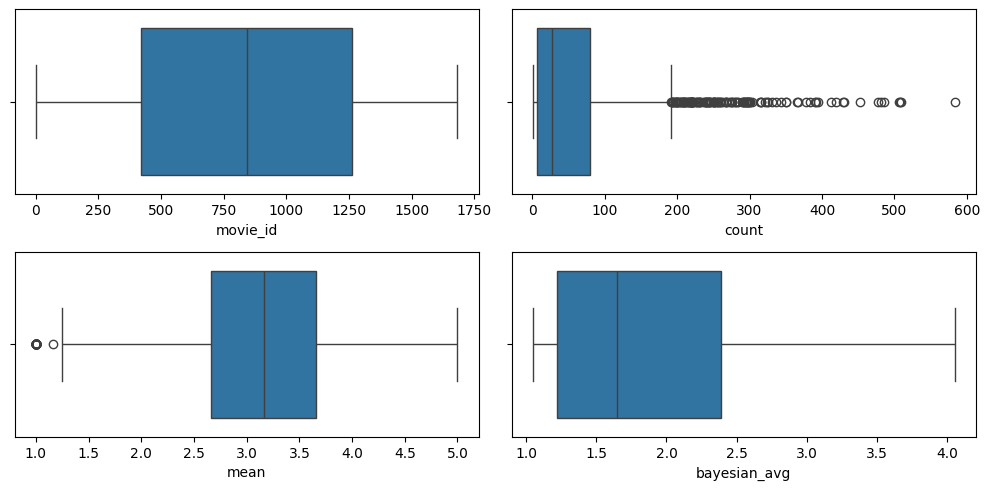

In [81]:
# Let's plot the outliers for movies_stats
# Boxplot for the first 6 values taking into cnsideration movies_stats
fig = plt.figure(figsize=(10,7))

for i in range(4): #for 4 columns
    fig.tight_layout()
    
    grid_col = "32{}".format(i+1)
    
    ax = fig.add_subplot(int(grid_col))
    
    sns.boxplot(data=movies_stats, x=col_names[i], ax=ax)
    
plt.show()

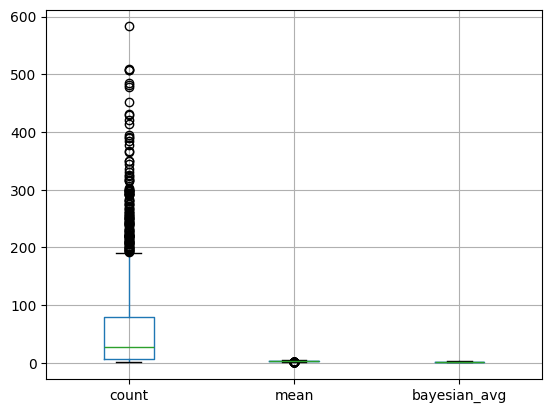

In [82]:
# boxplot for movies_stats
np.random.seed(1234)

plots = pd.DataFrame(np.random.randn(10, 3),

                  columns=['count', 'mean', 'bayesian_avg'])

boxplot = movies_stats.boxplot(column=['count', 'mean', 'bayesian_avg']) 

In [83]:
# violin plot based on movies_stats 
fig = px.violin(movies_stats, y="bayesian_avg", box=True, points="all",
          hover_data=movies_stats.columns)
fig.show()

In [84]:
# violin plot based on movie_id 
fig = px.violin(movies_stats, y="mean", box=True, points="all",
          hover_data=movies_stats.columns)
fig.show()

In [85]:
# Convert the data to a user-item matrix format
user_movie_ratings_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

# Display the user-item matrix
print("User-Movie Matrix:")
print(user_movie_ratings_matrix.head(15))

# Save the user-item matrix to a CSV file to investigate if it was correct
user_movie_ratings_matrix.to_csv('user_movie_ratings_matrix.csv')


User-Movie Matrix:
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6         4.0   NaN   NaN   NaN   NaN   NaN   2.0   4.0   4.0   NaN  ...   
7         NaN   NaN   NaN   5.0   NaN   NaN   5.0   5.0   5.0   4.0  ...   
8         NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN  ...   
9         NaN   NaN   NaN   NaN   NaN   5.0   4.0   NaN   NaN   NaN  ...   
10        4.0   NaN   NaN   4.0   NaN   NaN   4.0   NaN   4.0   NaN  ...   
11        NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   5.0   NaN  

In [100]:
# Matrix preparation - Optional
#Because the similarity computation requires complete data we replace all the missing values with zeros.
#Report - consine similarity- Να κάνουμε έρευνα για το ότι πρέπει να υπάρχει similarity στα κελιά των δεδομένων μας και επεξήγηση.
ratings_matrix_filled = user_movie_ratings_matrix.fillna(0)

In [101]:
#Let's see the number of rows and columns in our matrix.
ratings_matrix_filled.shape

(943, 1682)

In [111]:
#Let's evaluate our matrix. We will calculate sparsity.
n_total = ratings_matrix_filled.shape[0] * ratings_matrix_filled.shape[1] #total number of cells
n_ratings = np.count_nonzero(ratings_matrix_filled)
sparsity = n_ratings/n_total
print("Matrix sparsity: %s" %(round(sparsity,2)))

Matrix sparsity: 0.06


In [112]:
n_ratings_per_user = np.count_nonzero(ratings_matrix_filled, axis=1)
len(n_ratings_per_user)

943

In [115]:
#Let's find the most active and the less active users.
print("Most active users rated %s movies" %(n_ratings_per_user.max()))
print("Less active users rated %s movies" %(n_ratings_per_user.min()))

Most active users rated 737 movies
Less active users rated 20 movies


In [ ]:
### Q2: Basic Recommender System

In [106]:
#Splitting the dataset into training set and test set using sklearn.model_selection--->train_test_split
#https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html
split = ratings_matrix_filled.to_numpy()
x_train, x_test = train_test_split(split, test_size=0.2)
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (754, 1682)
Test set shape: (189, 1682)


In [ ]:
#####sort = ratings.sort_values(by='rating', ascending=False).head(5)-->To be removed
#Find the movies rated with a 5
top_rated_movies = ratings[ratings['rating'] == 5]
#Find the movies that have been rated with a 5 the most times
count_top_rated_by_item_id = top_rated_movies.groupby('item_id')['rating'].count()
#Top 10 movies rated with a 5 the most amount of times. This is the recommendation for each user of the test set
sorted_top_movies = count_top_rated_by_item_id.sort_values(ascending=False).head(10)
sorted_top_movies
#Recommends 10 movies at random
#https://saturncloud.io/blog/random-row-selection-in-pandas-dataframe/
random_indices = np.random.randint(0, len(ratings), size=10)
random_rows = ratings.iloc[random_indices]
random_rows

In [ ]:
### Q3: Collaborative Filtering - Recommender system

In [ ]:
# Compute cosine similarity between users.
similar_users = cosine_similarity(ratings_matrix_filled)
#Turn it to dataframe.
similar_users = pd.DataFrame(user_similarity, index=ratings_matrix_filled.index, columns = ratings_matrix_filled.index)
similar_users

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.118095,0.228583,0.026271,0.030138,0.071459,0.111852,0.107027,0.095898,0.039852,0.071460,...,0.066039,0.431154,0.258021,0.226449,0.432666,1.000000,0.087687,0.180029,0.043264,0.144250
940,0.314072,0.226790,0.161890,0.196858,0.239955,0.352449,0.329925,0.246883,0.120495,0.342961,...,0.327153,0.107024,0.187536,0.181317,0.175158,0.087687,1.000000,0.145152,0.261376,0.241028
941,0.148617,0.161485,0.101243,0.152041,0.139595,0.144446,0.059993,0.146145,0.143245,0.090305,...,0.046952,0.203301,0.288318,0.234211,0.313400,0.180029,0.145152,1.000000,0.101642,0.095120


In [107]:
# Let's find the k-most similar users for each user
# r = ratings_matrix_filled (the ratings matrix)
# k = similar_users (the number of most similar users)

r = ratings_matrix_filled
k= similar_users

def findKSimilar (r, k):
    
    # similarUsers is 2-D matrix
    similarUsers=-1*np.ones((nUsers,k))
    similarities=cosine_similarity(r)

# for each user
    
    # find the indexes of all  users similar to i, by increasing value of similarity
    for i in range(0, nUsers):
        simUsersIdxs= np.argsort(similarities[:,i])
        
        l=0
        #find its most similar users    
        for j in range(simUsersIdxs.size-2, simUsersIdxs.size-1-k-1,-1):
            print(simUsersIdxs[-k+1:],l)
            similarUsers[i,l]=simUsersIdxs[j]
            l=l+1
            
    return similarUsers, similarities

In [ ]:
# Predict for 'userId', the rating of 'itemId'. 
# A trivial implementation of a collaboarative system
#
#'r': is the ratings matrix
#'userId': is the userId, and 
#'itemID': is the item id    
#'similarUsers': contains for each user his most similar users
#'similarities': are th pairwise cosine similarities between the users
# returns the prediction.     
def predict(userId, itemId, r,similarUsers,similarities):

    # number of neighbours to consider
    nCols=similarUsers.shape[1]
    
    sum=0.0;
    simSum=0.0;
    for l in range(0,nCols):    
        neighbor=int(similarUsers[userId, l])
        #weighted sum
        sum= sum+ r[neighbor,itemId]*similarities[neighbor,userId]
        simSum = simSum + similarities[neighbor,userId]
    
    return  sum/simSum

In [ ]:
nUsers=943
nItems=1682
r=np.random.rand(nUsers, nItems)
#r=np.array([[3,0,3,3],[5,4,0,2],[1,2,4,2],[2,2,0,1]])

nRows=r.shape[0]
nCols=r.shape[1]
similarUsers, similarities=findKSimilar (r,2)

userId=0
itemId=0
prediction=predict(userId,itemId,r, similarUsers, similarities)
print ('prediction', prediction, 'real', r[userId,itemId])

[0] 0
[0] 1
[1] 0
[1] 1
[2] 0
[2] 1
[3] 0
[3] 1
[4] 0
[4] 1
[5] 0
[5] 1
[6] 0
[6] 1
[7] 0
[7] 1
[8] 0
[8] 1
[9] 0
[9] 1
[10] 0
[10] 1
[11] 0
[11] 1
[12] 0
[12] 1
[13] 0
[13] 1
[14] 0
[14] 1
[15] 0
[15] 1
[16] 0
[16] 1
[17] 0
[17] 1
[18] 0
[18] 1
[19] 0
[19] 1
[20] 0
[20] 1
[21] 0
[21] 1
[22] 0
[22] 1
[23] 0
[23] 1
[24] 0
[24] 1
[25] 0
[25] 1
[26] 0
[26] 1
[27] 0
[27] 1
[28] 0
[28] 1
[29] 0
[29] 1
[30] 0
[30] 1
[31] 0
[31] 1
[32] 0
[32] 1
[33] 0
[33] 1
[34] 0
[34] 1
[35] 0
[35] 1
[36] 0
[36] 1
[37] 0
[37] 1
[38] 0
[38] 1
[39] 0
[39] 1
[40] 0
[40] 1
[41] 0
[41] 1
[42] 0
[42] 1
[43] 0
[43] 1
[44] 0
[44] 1
[45] 0
[45] 1
[46] 0
[46] 1
[47] 0
[47] 1
[48] 0
[48] 1
[49] 0
[49] 1
[50] 0
[50] 1
[51] 0
[51] 1
[52] 0
[52] 1
[53] 0
[53] 1
[54] 0
[54] 1
[55] 0
[55] 1
[56] 0
[56] 1
[57] 0
[57] 1
[58] 0
[58] 1
[59] 0
[59] 1
[60] 0
[60] 1
[61] 0
[61] 1
[62] 0
[62] 1
[63] 0
[63] 1
[64] 0
[64] 1
[65] 0
[65] 1
[66] 0
[66] 1
[67] 0
[67] 1
[68] 0
[68] 1
[69] 0
[69] 1
[70] 0
[70] 1
[71] 0
[71] 1
[72] 0
[72] 